In [1]:
# !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
# !unzip uncased_L-12_H-768_A-12.zip

In [2]:
BERT_VOCAB = 'uncased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = 'uncased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = 'uncased_L-12_H-768_A-12/bert_config.json'

In [3]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling

In [4]:
tokenization.validate_case_matches_checkpoint(True,BERT_INIT_CHKPNT)
tokenizer = tokenization.FullTokenizer(
      vocab_file=BERT_VOCAB, do_lower_case=True)

In [5]:
from utils import *
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import time
import random

/home/husein/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset,1.0)
print (trainset.target_names)
print (len(trainset.data))
print (len(trainset.target))

['negative', 'positive']
10662
10662


In [7]:
MAX_SEQ_LENGTH = 100

In [8]:
from tqdm import tqdm

input_ids, input_masks, segment_ids = [], [], []

for text in tqdm(trainset.data):
    tokens_a = tokenizer.tokenize(text)
    if len(tokens_a) > MAX_SEQ_LENGTH - 2:
        tokens_a = tokens_a[:(MAX_SEQ_LENGTH - 2)]
    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segment_id = [0] * len(tokens)
    input_id = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_id)
    padding = [0] * (MAX_SEQ_LENGTH - len(input_id))
    input_id += padding
    input_mask += padding
    segment_id += padding
    
    input_ids.append(input_id)
    input_masks.append(input_mask)
    segment_ids.append(segment_id)

100%|██████████| 10662/10662 [00:03<00:00, 3547.96it/s]


In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(input_ids, trainset.target,
                                                    test_size = 0.2)

In [10]:
def _pairwise_distances(embeddings, squared=False):
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
    distances = tf.maximum(distances, 0.0)

    if not squared:
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16
        distances = tf.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets

In [11]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
epoch = 10
batch_size = 3
warmup_proportion = 0.1
num_train_steps = int(len(input_ids) / batch_size * epoch)
num_warmup_steps = int(num_train_steps * warmup_proportion)

In [12]:
class Model:
    def __init__(self, dimension_output):
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        
        model = modeling.BertModel(
            config=bert_config,
            is_training=True,
            input_ids=self.X,
            use_one_hot_embeddings=False)
        
        output_layer = model.get_pooled_output()
        self.logits = tf.layers.dense(output_layer, dimension_output)
        self.cost, fraction = batch_all_triplet_loss(self.Y, self.logits, margin=0.5, squared=False)
        
        self.optimizer = optimization.create_optimizer(self.cost, 2e-5, 
                                                       num_train_steps, num_warmup_steps, False)

In [13]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(2)
sess.run(tf.global_variables_initializer())

In [14]:
var_lists = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'bert')
saver = tf.train.Saver(var_list = var_lists)
saver.restore(sess, BERT_INIT_CHKPNT)

INFO:tensorflow:Restoring parameters from uncased_L-12_H-768_A-12/bert_model.ckpt


In [15]:
for e in range(10):
    total_loss = 0
    pbar = tqdm(
        range(0,len(train_X),batch_size), desc = 'train minibatch loop'
    )
    for index in pbar:
        
        batch_x = train_X[index:min(index+batch_size,len(train_X))]
        batch_y = train_Y[index:min(index+batch_size,len(train_X))]
        loss, _ = sess.run([model.cost,model.optimizer],feed_dict={model.X:batch_x,model.Y:batch_y})
        total_loss += loss
        pbar.set_postfix(cost = loss)
    total_loss /= len(train_X) / batch_size
    print('epoch: %d, avg cost: %f'%(e+1,total_loss))

train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 1, avg cost: 0.372676


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 2, avg cost: 0.366336


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 3, avg cost: 0.368754


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 4, avg cost: 0.368195


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 5, avg cost: 0.368211


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 6, avg cost: 0.368046


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 7, avg cost: 0.367200


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 8, avg cost: 0.368411


train minibatch loop:   0%|          | 0/2843 [00:00<?, ?it/s]

epoch: 9, avg cost: 0.368011


train minibatch loop: 100%|██████████| 2843/2843 [14:04<00:00,  3.37it/s, cost=0.483]

epoch: 10, avg cost: 0.368287


In [16]:
logits_train = []

for index in range(0,len(train_X),batch_size):
    batch_x = train_X[index:min(index+batch_size,len(train_X))]
    l = sess.run(model.logits,feed_dict={model.X:batch_x})
    logits_train.extend(l.tolist())
    
logits_train = np.array(logits_train)
logits_train.shape

(8529, 2)

In [17]:
logits_test = []

for index in range(0,len(test_X),batch_size):
    batch_x = test_X[index:min(index+batch_size,len(test_X))]
    l = sess.run(model.logits,feed_dict={model.X:batch_x})
    logits_test.extend(l.tolist())
    
logits_test = np.array(logits_test)
logits_test.shape

(2133, 2)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

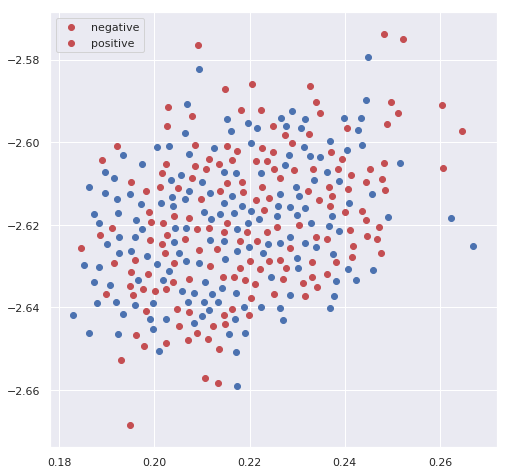

In [19]:
ax_min = np.min(logits_test,0)
ax_max = np.max(logits_test,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
shown_images = np.array([[1., 1.]])
colors = ['b','r']
for i in range(logits_test.shape[0]):
    dist = np.sum((logits_test[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [logits_test[i]]]
    plt.scatter(logits_test[i,0],logits_test[i,1],c=colors[test_Y[i]])
plt.legend(['negative','positive'])
plt.show()

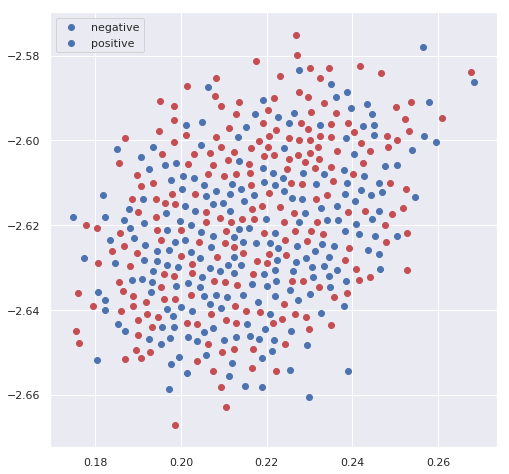

In [20]:
ax_min = np.min(logits_train,0)
ax_max = np.max(logits_train,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
shown_images = np.array([[1., 1.]])
colors = ['b','r']
for i in range(logits_train.shape[0]):
    dist = np.sum((logits_train[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [logits_train[i]]]
    plt.scatter(logits_train[i,0],logits_train[i,1],c=colors[train_Y[i]])
plt.legend(['negative','positive'])
plt.show()